In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import scipy as sp
import os
import pickle
from decimal import Decimal
import h5py
import itertools
from collections import OrderedDict
import imp
from tqdm import tqdm

from scipy.stats import norm

import astropy.constants as C
import astropy.units as u
import astropy as ap

import peters
import bounded_Nd_kde
from IPython.core.debugger import set_trace
from importlib import reload

from matplotlib import gridspec
import matplotlib
from matplotlib import ticker
%matplotlib inline
import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LogLocator

cp = sns.color_palette("colorblind", 6)

plt.style.use("/Users/michaelzevin/.MATPLOTLIB_RCPARAMS.sty")

In [15]:
alpha_val = '10'
models_path = '/Users/michaelzevin/research/model_selection/model_selection/data/spin_models/models_reduced.hdf5'
sensitivity = 'design'
param_dict = {'mchirp':r'$\mathcal{M}_c\ [\mathrm{M}_\odot]$', 'q':r'$q$', 'chieff':r'$\chi_{\rm eff}$', 'z':r'$z$'}
param_lims = {'mchirp':(0,100), 'q':(0,1), 'chieff':(-1,1), 'z':(0,2)}
smdl_dict = {'chi00':r'$\chi_b = 0.0$', 'chi01':r'$\chi_b = 0.1$', 'chi02':r'$\chi_b = 0.2$', 'chi05':r'$\chi_b = 0.5$'}

In [23]:
all_models = []
models = []
def find_submodels(name, obj):
    if isinstance(obj, h5py.Dataset):
        all_models.append(name.rsplit('/', 1)[0])
        
f = h5py.File(models_path, 'r')
f.visititems(find_submodels)
# get all unique models
all_models = sorted(list(set(all_models)))
f.close()

# use only models with given alpha value
for model in all_models:
    if 'alpha' in model:
        if 'alpha'+alpha_val in model:
            models.append(model)
    else:
        models.append(model)
        

In [24]:
channels = sorted(set([x.split('/')[0] for x in models]))
smdls = sorted(set([x.split('/')[1] for x in models]))

### Plot detection-weighted KDEs against underlying population

CE
  chi00
  chi01
  chi02
  chi05
CHE
  chi00
  chi01
  chi02
  chi05
GC
  chi00
  chi01
  chi02
  chi05
NSC
  chi00
  chi01
  chi02
  chi05
SMT
  chi00
  chi01
  chi02
  chi05
TRIP
  chi00
  chi01
  chi02
  chi05


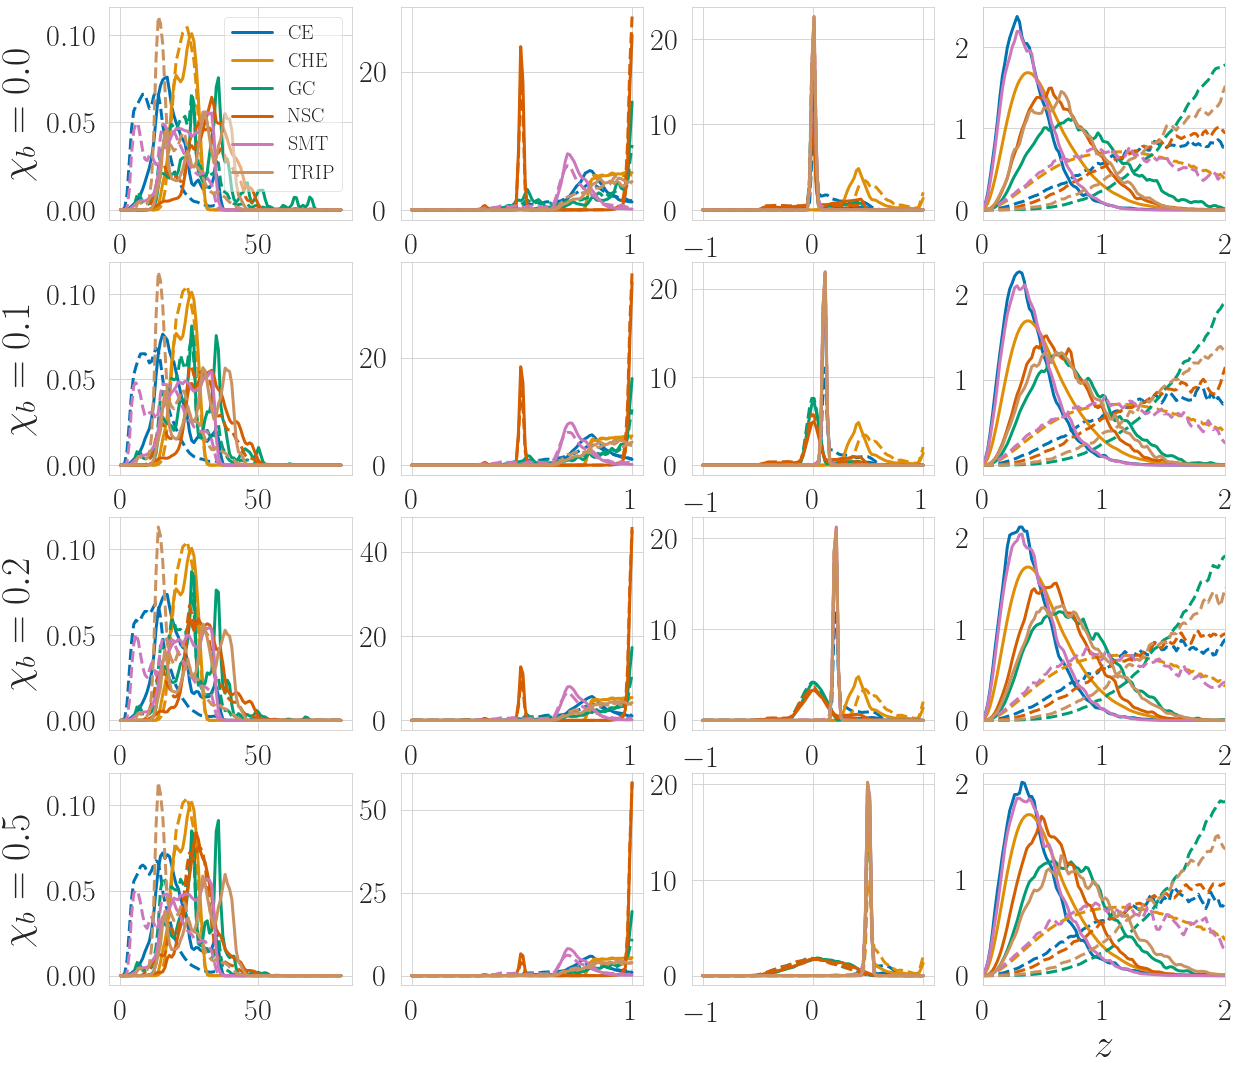

In [7]:
Nsamp = 100000
bw = 0.01

fig, axs = plt.subplots(len(smdls),len(param_dict), figsize=(20,18))

for cidx, chnl in enumerate(channels):
    print(chnl)
    #if chnl!='GC':
    #    continue
    for midx, smdl in enumerate(smdls):
        print('  '+smdl)
        key = [i for i in models if chnl in i and smdl in i][0]
        df = pd.read_hdf(models_path, key=key)
        df_cut = df.sample(Nsamp) if len(df)>Nsamp else df.copy()
        
        for pidx, param in enumerate(param_dict.keys()):
        
            ax = axs[midx, pidx]
            if (cidx==0) and (pidx==0):
                ax.set_ylabel(smdl_dict[smdl])
            
            xsmooth = np.linspace(*param_lims[param], 100)
            dx = xsmooth[1]-xsmooth[0]
            
            # unweighted
            weighting=None
            weighting=df_cut['weight']/np.sum(df_cut['weight'])
            kde = bounded_Nd_kde.Bounded_Nd_kde(np.atleast_2d(df_cut[param]), bounds=param_lims[param], bw_method=bw, weights=weighting)
            
            # weighted: combine cosmological and pdet weights
            weighting =  (df_cut['weight']/np.sum(df_cut['weight'])) * (df_cut[sensitivity]/np.sum(df_cut[sensitivity]))
            kde_weighted = bounded_Nd_kde.Bounded_Nd_kde(np.atleast_2d(df_cut[param]), bounds=param_lims[param], bw_method=bw, weights=weighting)
            
            kde_eval = kde(xsmooth)
            kde_weighted_eval = kde_weighted(xsmooth)
            
            ax.plot(xsmooth, kde_eval, color=cp[cidx], linestyle='--')
            ax.plot(xsmooth, kde_weighted_eval, color=cp[cidx], label=chnl)
            
        if midx==len(smdls)-1:
            ax.set_xlabel(param_dict[param])
            
        ax.set_xlim(param_lims[param])
            
axs[0,0].legend(prop={'size':20})

### Test bounded, weighted KDEs

In [128]:
df = pd.read_hdf(models_path, key='GC/chi01')
Nsamp = 100000
bw = 0.02
normalized = False
df = df.sample(Nsamp) if len(df)>Nsamp else df
df['combined_weight'] = (df['weight']/np.sum(df['weight'])) * (df['pdet_'+sensitivity]/np.sum(df['pdet_'+sensitivity]))
df['combined_weight'] /= np.sum(df['combined_weight'])

if normalized == True:
    # Normalize the samples
    params = ['mchirp','q','chieff','z']
    for param in params:
        df[param] = (df[param]-param_lims[param][0])/(param_lims[param][1]-param_lims[param][0])
        
reload(bounded_Nd_kde)

<module 'bounded_Nd_kde' from '/Users/michaelzevin/research/utilities/bounded_Nd_kde.py'>

#### Test 1D KDE

In [54]:
param='mchirp'
xsmooth = np.linspace(*param_lims[param], 101)

kde = bounded_Nd_kde.Bounded_Nd_kde(np.atleast_2d(df[param]), bounds=param_lims[param], bw_method=bw)
kde_weighted = bounded_Nd_kde.Bounded_Nd_kde(np.atleast_2d(df[param]), bounds=param_lims[param], bw_method=bw, weights=np.asarray(df['combined_weight']))
kde_eval = kde(xsmooth)
kde_eval_weighted = kde_weighted(xsmooth)

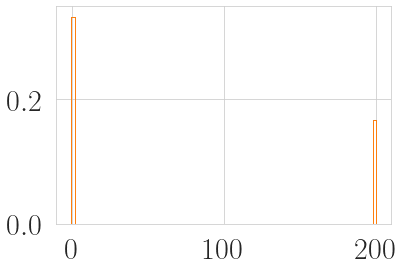

In [55]:
# plot all reflected points
_ = plt.hist(kde.dataset[0], bins=100, density=True, histtype='step')
_ = plt.hist(kde_weighted.dataset[0], bins=100, weights=kde_weighted._weights, density=True, histtype='step')

Integrated KDE: 1.00
Integrated weighted KDE: 1.00


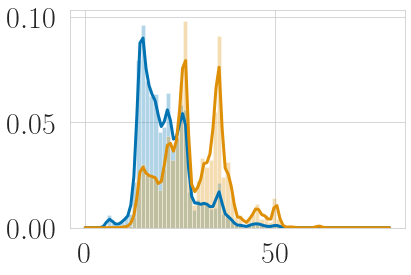

In [8]:
# plot KDEs against actual data
_ = plt.plot(xsmooth, kde_eval, color=cp[0])
_ = plt.hist(df[param], bins=50, density=True, alpha=0.3, color=cp[0])
print('Integrated KDE: {:0.2f}'.format(np.trapz(kde_eval, xsmooth)))

_ = plt.plot(xsmooth, kde_eval_weighted, color=cp[1])
_ = plt.hist(df[param], bins=50, weights=np.asarray(df['combined_weight']), density=True, alpha=0.3, color=cp[1])
print('Integrated weighted KDE: {:0.2f}'.format(np.trapz(kde_eval_weighted, xsmooth)))

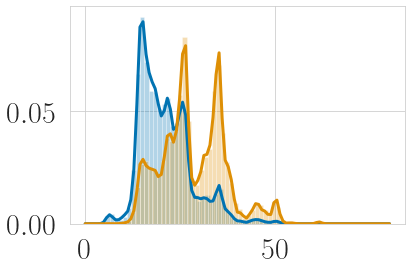

In [9]:
# draw from KDEs
N=10000
resamp = kde.bounded_resample(N)
resamp_weighted = kde_weighted.bounded_resample(N)

_ = plt.plot(xsmooth, kde_eval, color=cp[0])
_ = plt.hist(resamp[0], bins=50, density=True, alpha=0.3, color=cp[0])

_ = plt.plot(xsmooth, kde_eval_weighted, color=cp[1])
_ = plt.hist(resamp_weighted[0], bins=50, density=True, alpha=0.3, color=cp[1])


#### Test 2D kde
$ N_{\rm sides} = 2N $

$ N_{\rm vert} = 2^N $

$ N_{pts} = N_{pts,0} * (1 + N_{\rm sides} + N_{\rm vert}) $

In [242]:
params=['chieff','q']
eval_pts = np.asarray([np.linspace(*param_lims[params[0]], 101), np.linspace(*param_lims[params[1]], 101)])

X = np.atleast_2d([df[params[0]],df[params[1]]])
Bounds = np.atleast_2d([param_lims[params[0]],param_lims[params[1]]])

kde = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=bw)
kde_weighted = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=bw, weights=np.asarray(df['combined_weight']))
kde_eval = kde(eval_pts)
kde_eval_weighted = kde_weighted(eval_pts)

In [243]:
print('Nrefl: {}'.format(kde._refl_norm_factor))

Nrefl: 9


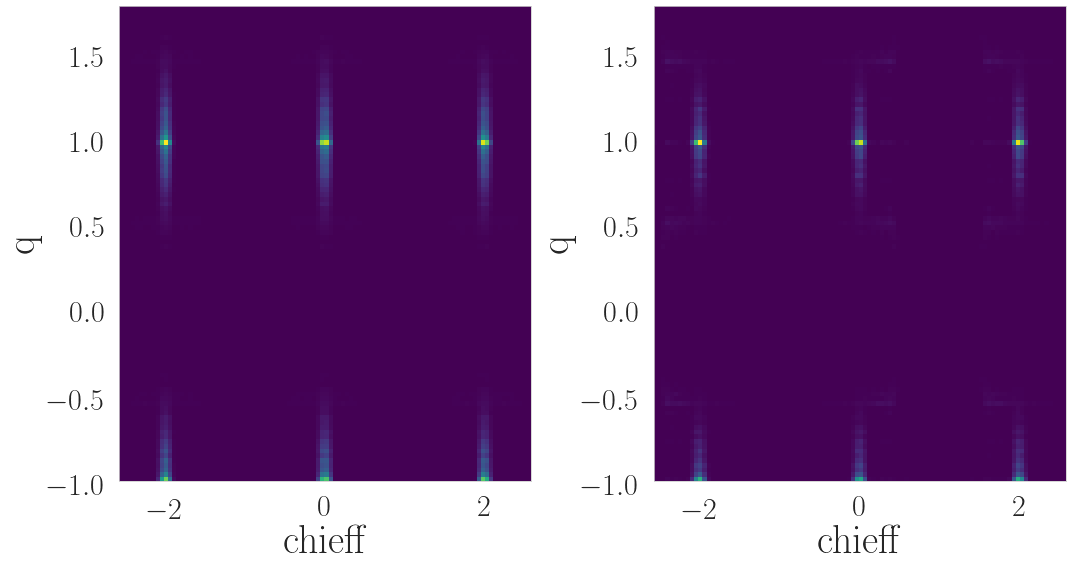

In [244]:
# plot all reflected points
fig, axs = plt.subplots(1,2, figsize=(15,8))
_ = axs[0].hist2d(kde.dataset[0], kde.dataset[1], bins=100, density=True)
_ = axs[1].hist2d(kde_weighted.dataset[0], kde_weighted.dataset[1], bins=100, weights=kde_weighted._weights, density=True)

for ax in axs:
    ax.set_xlabel(params[0])
    ax.set_ylabel(params[1])
    
plt.tight_layout()

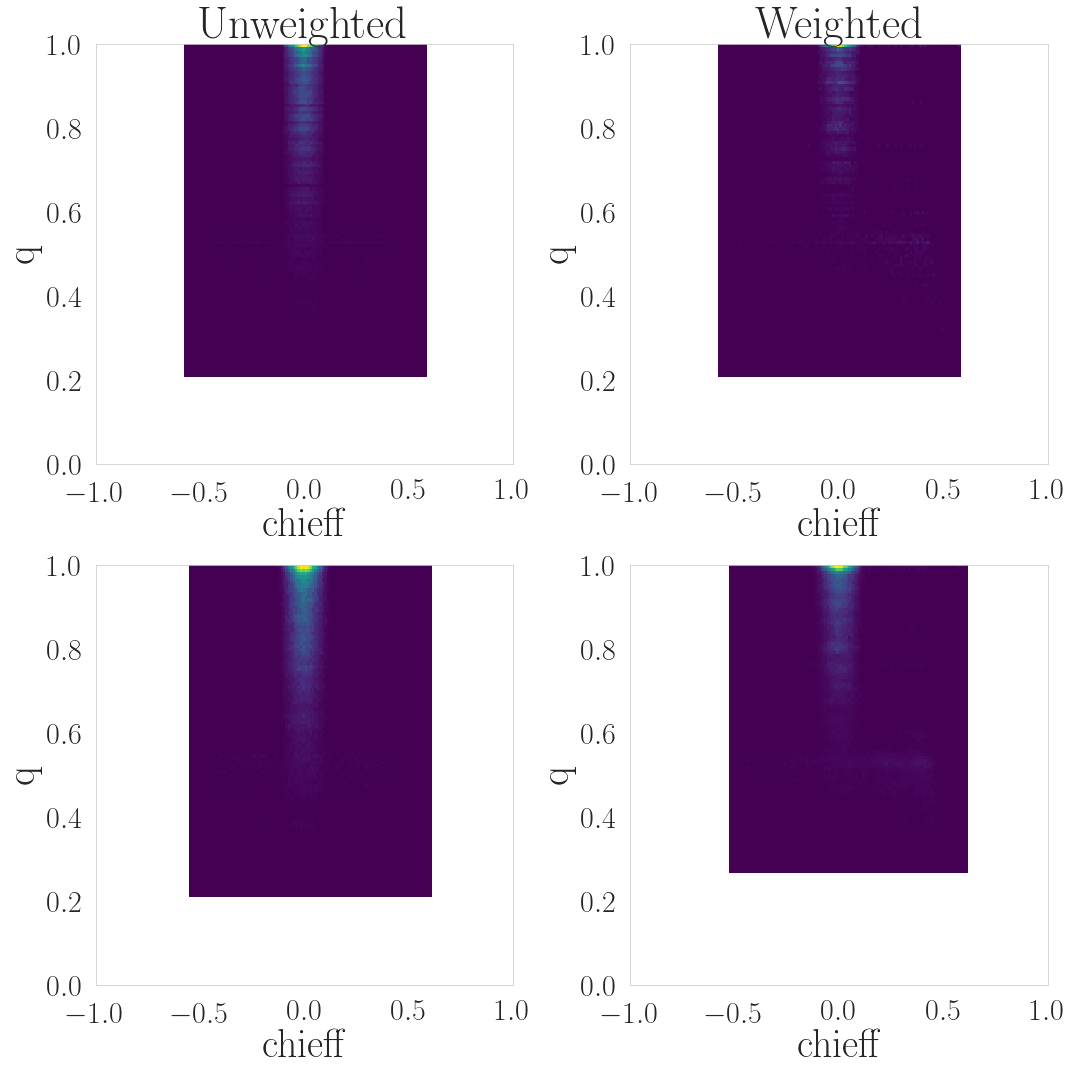

In [245]:
# plot 2D KDEs against actual data
N=100000

fig, axs = plt.subplots(2,2, figsize=(15,15))
axs[0,0].set_title('Unweighted')
axs[0,1].set_title('Weighted')

# unweighted comparison
axs[0,0].hist2d(df[params[0]], df[params[1]], bins=100, density=True)
resamp = kde.bounded_resample(N)
axs[1,0].hist2d(resamp[0], resamp[1], bins=100, density=True)

# weighted comparison
axs[0,1].hist2d(df[params[0]], df[params[1]], bins=100, density=True, weights=np.asarray(df['combined_weight']))
resamp_weighted = kde_weighted.bounded_resample(N)
axs[1,1].hist2d(resamp_weighted[0], resamp_weighted[1], bins=100, density=True)

for ax in axs.flatten():
    ax.set_xlabel(params[0])
    ax.set_ylabel(params[1])
    ax.set_xlim(*param_lims[params[0]])
    ax.set_ylim(*param_lims[params[1]])
    
plt.tight_layout()

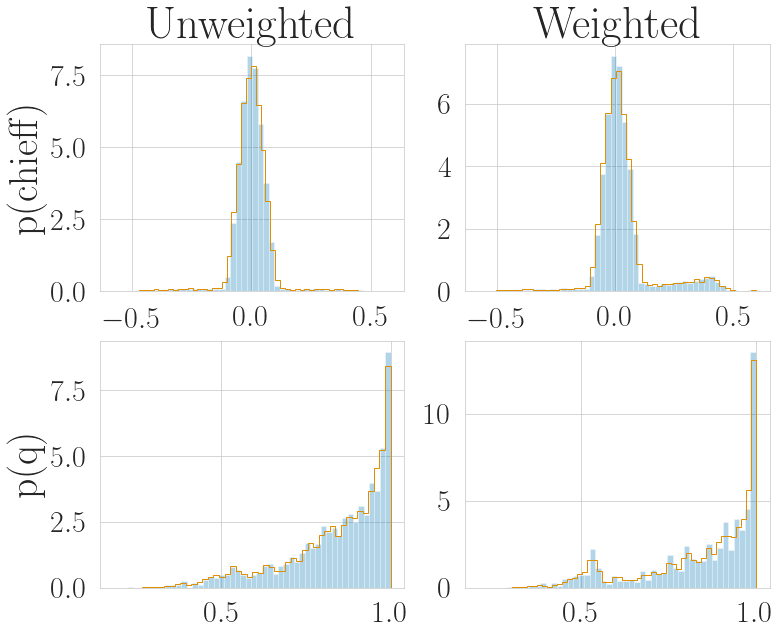

In [246]:
# check 1D distributions against KDE resample
N=10000

fig, axs = plt.subplots(len(params),2, figsize=(12,5*len(params)))

axs[0,0].set_title('Unweighted')
axs[0,1].set_title('Weighted')


resamp = kde.bounded_resample(N)
resamp_weighted = kde_weighted.bounded_resample(N)
for idx, param in enumerate(params):
    axs[idx,0].set_ylabel('p({:s})'.format(params[idx]))
    
    _ = axs[idx,0].hist(df[param], bins=50, density=True, alpha=0.3, color=cp[0])
    _ = axs[idx,0].hist(resamp[idx], bins=50, density=True, histtype='step', color=cp[1])
    
    _ = axs[idx,1].hist(df[param], bins=50, density=True, weights=np.asarray(df['combined_weight']), alpha=0.3, color=cp[0])
    _ = axs[idx,1].hist(resamp_weighted[idx], bins=50, density=True, histtype='step', color=cp[1])

### Check that >2D has the right number of reflections and points

#### 3D

In [247]:
params=['mchirp','q','z']
eval_pts = np.asarray([np.linspace(*param_lims[params[0]], 101), np.linspace(*param_lims[params[1]], 101), np.linspace(*param_lims[params[2]], 101)])

X = np.atleast_2d([df[params[0]],df[params[1]],df[params[2]]])
Bounds = np.atleast_2d([param_lims[params[0]],param_lims[params[1]],param_lims[params[2]]])

kde = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=bw)
kde_weighted = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=bw, weights=np.asarray(df['combined_weight']))
kde_eval = kde(eval_pts)
kde_eval_weighted = kde_weighted(eval_pts)

In [248]:
print('Nrefl: {}'.format(kde._refl_norm_factor))

Nrefl: 15


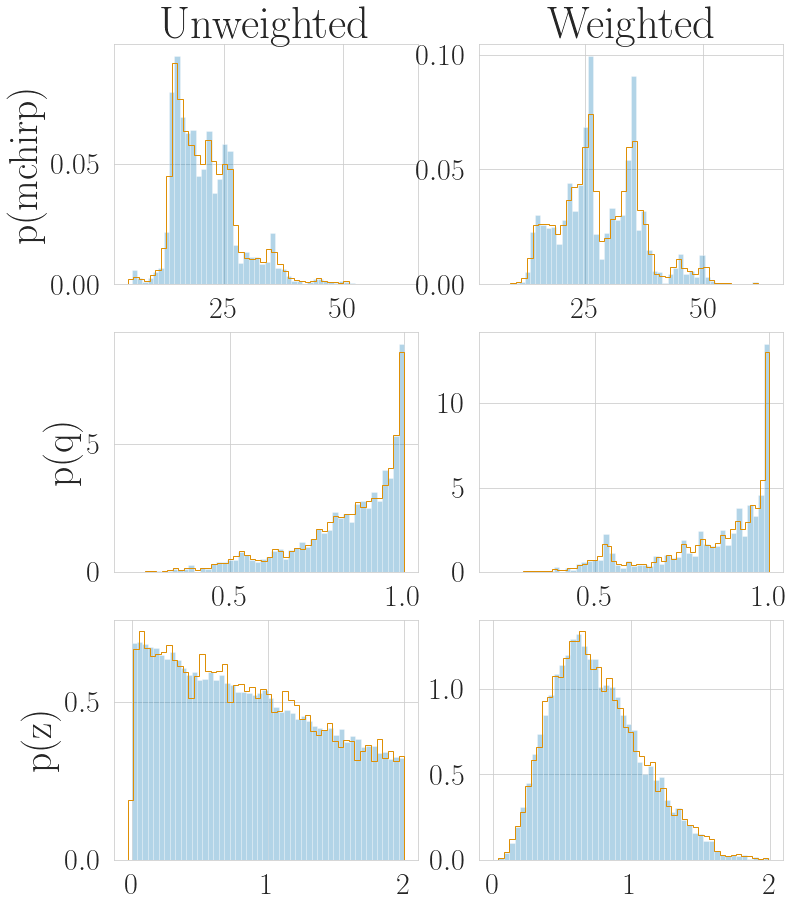

In [249]:
# check 1D distributions against KDE resample
N=10000

fig, axs = plt.subplots(len(params),2, figsize=(12,5*len(params)))

axs[0,0].set_title('Unweighted')
axs[0,1].set_title('Weighted')


resamp = kde.bounded_resample(N)
resamp_weighted = kde_weighted.bounded_resample(N)
for idx, param in enumerate(params):
    axs[idx,0].set_ylabel('p({:s})'.format(params[idx]))
    
    _ = axs[idx,0].hist(df[param], bins=50, density=True, alpha=0.3, color=cp[0])
    _ = axs[idx,0].hist(resamp[idx], bins=50, density=True, histtype='step', color=cp[1])
    
    _ = axs[idx,1].hist(df[param], bins=50, density=True, weights=np.asarray(df['combined_weight']), alpha=0.3, color=cp[0])
    _ = axs[idx,1].hist(resamp_weighted[idx], bins=50, density=True, histtype='step', color=cp[1])

#### 4D

In [129]:
params=['mchirp','q','chieff','z']
eval_pts = np.asarray([np.linspace(*param_lims[params[0]], 101), np.linspace(*param_lims[params[1]], 101), \
                       np.linspace(*param_lims[params[2]], 101), np.linspace(*param_lims[params[3]], 101)])

X = np.atleast_2d([df[params[0]],df[params[1]],df[params[2]],df[params[3]]])
Bounds = np.atleast_2d([param_lims[params[0]],param_lims[params[1]],param_lims[params[2]],param_lims[params[3]]])

if normalized == True:
    Bounds = np.atleast_2d([(0,1),(0,1),(0,1),(0,1)])
    eval_pts = np.asarray([np.linspace(0,1, 101), np.linspace(0,1, 101), np.linspace(0,1, 101), np.linspace(0,1, 101)])


kde = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=bw)
kde_weighted = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=bw, weights=np.asarray(df['combined_weight']))
kde_eval = kde(eval_pts)
kde_eval_weighted = kde_weighted(eval_pts)

In [130]:
print('Nrefl: {}'.format(kde._refl_norm_factor))

Nrefl: 25


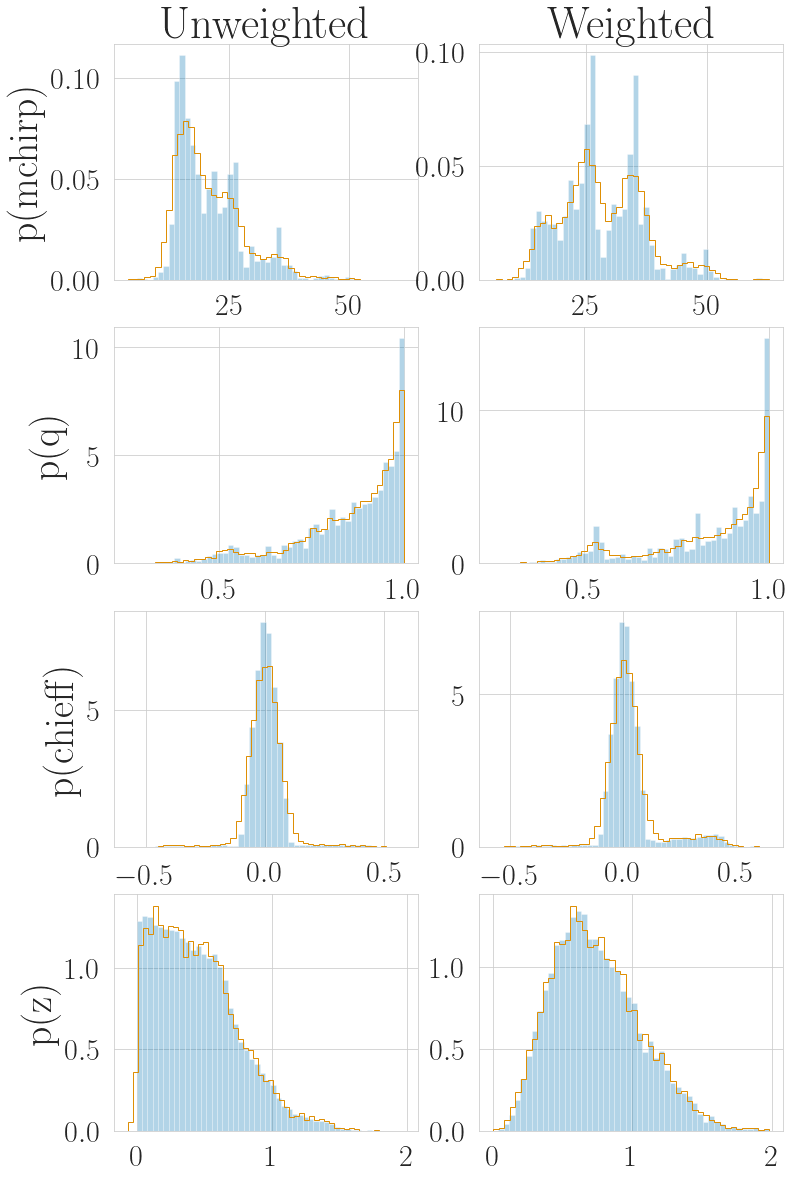

In [131]:
# check 1D distributions against KDE resample
N=10000

fig, axs = plt.subplots(len(params),2, figsize=(12,5*len(params)))

axs[0,0].set_title('Unweighted')
axs[0,1].set_title('Weighted')


resamp = kde.bounded_resample(N)
resamp_weighted = kde_weighted.bounded_resample(N)
for idx, param in enumerate(params):
    axs[idx,0].set_ylabel('p({:s})'.format(params[idx]))
    
    if normalized == True:
        _ = axs[idx,0].hist(df[param]*(param_lims[param][1]-param_lims[param][0]) + param_lims[param][0], bins=50, density=True, alpha=0.3, color=cp[0])
        _ = axs[idx,0].hist(resamp[idx]*(param_lims[param][1]-param_lims[param][0]) + param_lims[param][0], bins=50, density=True, histtype='step', color=cp[1])
        _ = axs[idx,1].hist(df[param]*(param_lims[param][1]-param_lims[param][0]) + param_lims[param][0], bins=50, density=True, weights=np.asarray(df['combined_weight']), alpha=0.3, color=cp[0])
        _ = axs[idx,1].hist(resamp_weighted[idx]*(param_lims[param][1]-param_lims[param][0]) + param_lims[param][0], bins=50, density=True, histtype='step', color=cp[1])
    else:
        _ = axs[idx,0].hist(df[param], bins=50, density=True, alpha=0.3, color=cp[0])
        _ = axs[idx,0].hist(resamp[idx], bins=50, density=True, histtype='step', color=cp[1]) 
        _ = axs[idx,1].hist(df[param], bins=50, density=True, weights=np.asarray(df['combined_weight']), alpha=0.3, color=cp[0])
        _ = axs[idx,1].hist(resamp_weighted[idx], bins=50, density=True, histtype='step', color=cp[1])


### Check rates for Simone

In [2]:
alpha=1.0
models_path = '/Users/michaelzevin/research/model_selection/model_selection/data/spin_models/weighted_models.hdf5'
sensitivity='design'

# get raw data and total weights (yr^-1)
CE_data = np.load('spin_models/CE/infinite_sensitivity_alpha_'+str(alpha)+'.npz')
SMT_data = np.load('spin_models/SMT/infinite_sensitivity_alpha_'+str(alpha)+'.npz')
CE_total_weight = np.sum(CE_data['weights'])
SMT_total_weight = np.sum(SMT_data['weights'])

# get downsampled data and total weights
data_downsamp = pd.read_hdf(models_path, key='ISO/chi00/alpha10')
data_downsamp = data_downsamp.sample(50000, weights=data_downsamp['weight'])
CE_data_downsamp = data_downsamp.loc[data_downsamp['subchannel']=='CE']
SMT_data_downsamp = data_downsamp.loc[data_downsamp['subchannel']=='SMT']
CE_downsamp_weight = np.sum(CE_data_downsamp['weight'])
SMT_downsamp_weight = np.sum(SMT_data_downsamp['weight'])

# get normalization factors
CE_norm = CE_total_weight/CE_downsamp_weight
SMT_norm = SMT_total_weight/SMT_downsamp_weight

# get detection rates
det_rate_CE = CE_norm * np.sum(CE_data_downsamp[sensitivity] * CE_data_downsamp['weight'])
det_rate_SMT = SMT_norm * np.sum(SMT_data_downsamp[sensitivity] * SMT_data_downsamp['weight'])

print('For {} sensitivity, the rates are: '.format(sensitivity))
print('   CE: {:0.2f} yr^-1'.format(det_rate_CE))
print('   SMT: {:0.2f} yr^-1'.format(det_rate_SMT))

For design sensitivity, the rates are: 
   CE: 19.42 yr^-1
   SMT: 10.06 yr^-1


In [524]:
# Let's use his full population and see how the rate changes as a function of N_sample (NOTE: this is a few Gb!)

df = pd.read_csv('/Users/michaelzevin/Desktop/midhighlatelow_sensitivity_alpha_1.0_three_detectors', index_col=0)

In [571]:
def downsampled_rate(df, N, weighted_resample=True):
    weights = df['weights'] if weighted_resample else None
    df_cut = df.sample(N, weights=weights, replace=False)
    norm_fac = np.sum(df['weights']) / np.sum(df_cut['weights'])
    rate = np.sum((df_cut['weights'] * df_cut['midhighlatelow_network']))
    return norm_fac * rate

In [580]:
#Nds = np.logspace(np.log10(10000), np.log10(len(df)), 10)
Nds = np.linspace(100000, len(df), 20)

rates = []
for N in tqdm(Nds):
    N = int(np.floor(N))
    rates.append(downsampled_rate(df, N, weighted_resample=False))

100%|██████████| 20/20 [01:26<00:00,  4.32s/it]


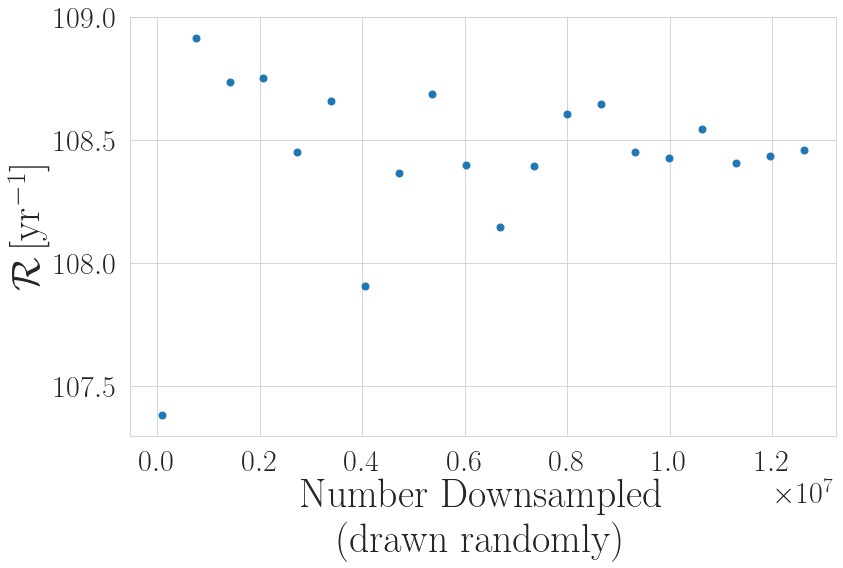

In [581]:
fig, axs = plt.subplots(figsize=(12,8))
axs.scatter(Nds, rates)
axs.set_xlabel('Number Downsampled\n(drawn randomly)')
axs.set_ylabel(r'$\mathcal{R}\,[\mathrm{yr}^{-1}]$')
plt.tight_layout()
plt.savefig('/Users/michaelzevin/Desktop/R_vs_Ndownsamp_unweighted_draws.png')